In [28]:
from functions import map_scatter, glasbey
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
import copy
import os

In [3]:
# read in dimred_clstr data
data_path = os.path.join('..', 'outputs', 'data.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    print(f"File not found: {data_path}.\nCheck data path.")

In [4]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'UMAP1',
       'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint'],
      dtype='object')

In [5]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1', 'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint']
markers = [col for col in df.columns if col not in metadata]
print(markers)

['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']


In [4]:
print(len(df[df['Classification'] == 'Other/NA']))
print(len(df[df['Classification'] != 'Other/NA']))

921719
3826900


### Hierarchical Clustering
Based on Figure S1C of [this](https://pubmed.ncbi.nlm.nih.gov/37059105/) paper.

Level 1 clustermap on a random subset

In [8]:
# get the proportion of each group in level 1
for p in df['Level 1'].unique():
    prop = len(df[df['Level 1'] == p]) / len(df.index)
    print(p, prop)
    

Other 0.5528457852693593
Immune 0.445418552214865
Epithelial 0.0017356625157756392


In [9]:
# reduce size by getting mean within lymph nodes within level
df_mean = df[markers + ['Parent', 'Level 1']].groupby(['Parent']).mean(numeric_only=True).reset_index()

In [10]:
df_mean.head()

,Parent,DAPI,CD44,HLA-DR,CD4,IFNG,Ki67,CD107a,CD45,CD20,...,T-bet/TBX21,PD-L1,TOX,PD-1,CD38,ICOS,CD39,LAG3,TCF-1,CD3e
0,Slide 10 C1,0.112654,0.326746,-0.001500,0.133345,-0.037869,-0.075604,0.139179,0.269642,0.279431,...,-0.441919,0.147788,0.288457,-0.090116,0.004528,0.090225,0.113140,0.026987,0.316915,0.255321
1,Slide 10 C1-1,-0.171726,-0.088561,-0.106038,-0.307162,0.008308,-0.001743,-0.068358,-0.213336,-0.171941,...,0.546104,-0.133572,-0.135294,-0.293831,0.111660,-0.282644,-0.027898,-0.290920,-0.218998,-0.294587
2,Slide 10 D1,0.075491,-0.195875,0.108724,0.194600,0.024682,0.067845,-0.052401,-0.019571,-0.070059,...,-0.166938,0.006134,-0.115071,0.376407,-0.117066,0.207451,-0.070627,0.271107,-0.055154,0.075250
3,Slide 11 A1,0.219822,-0.087645,-0.005068,0.202881,-0.031256,0.285999,-0.139885,-0.091552,0.076618,...,-0.231152,0.246357,0.215293,0.313688,-0.101141,0.378709,0.105011,-0.607268,0.230345,0.271279
4,Slide 11 A1-1,0.038314,-0.011515,0.161775,0.042760,0.011698,0.137557,0.238939,0.014951,0.076359,...,0.252214,-0.124502,-0.005044,-0.026457,0.252023,-0.052302,-0.006979,0.260339,0.035833,-0.039328


In [11]:
df_mean.columns

Index(['Parent', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a',
       'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A',
       'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56',
       'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX',
       'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e'],
      dtype='object')

In [12]:
# reduce size by getting sample
lvl1_markers = ['CD45', 'Pan-Cytokeratin', 'CD3e', 'CD20', 'CD11c']
df_ss = df.sample(frac=0.1, random_state=57)

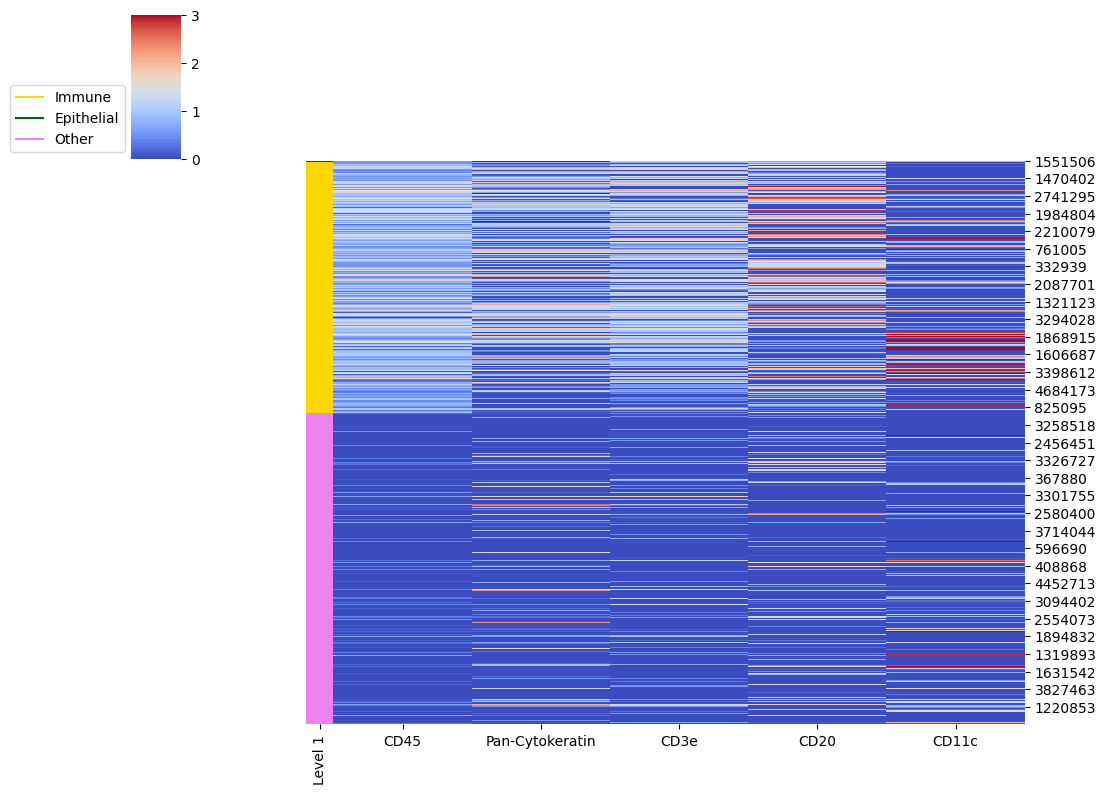

In [13]:
level1_colours = {
    'Immune': 'gold',
    'Epithelial': 'darkgreen',
    'Other': 'violet'
}

df_sorted = df_ss.sort_values(by=['Level 1', 'Level 2'])
row_colours = df_sorted['Level 1'].map(level1_colours) # map each row to a colour based on level
df_biomarkers = df_sorted[lvl1_markers] 

# plot
cg = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cg.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
for label in level1_colours:
    plt.plot([], [], color=level1_colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

In [14]:
# reduce size by getting sample
filtered = df_ss[df_ss['Level 1'] == 'Immune'] # get the immune subset

In [15]:
rest_markers = ['CD3e', 'CD8', 'TCF-1', 'PD-1', 'TOX', 'CD39', 'FOXP3', 'CD68', 'CD11c', 'CD107a', 'CD56', 'Granzyme B']

levels = ['Level 2', 'Level 3', 'Level 4']

level2_colours = {
    'Lymphoid': 'gold',
    'Myeloid': 'darkorange',
    'Other': 'white'
}

level3_colours = {
    'Helper T': 'rebeccapurple',
    'Macrophage': 'paleturquoise',
    'Cyt T': 'mediumseagreen',
    'Dendritic': 'hotpink',
    'NK Cell': 'sienna',
    'Other': 'white'
}

level4_colours = {
    'T reg': 'gold',
    'Cyt T Precursor': 'blue',
    'Helper T Precursor': 'greenyellow',
    'Tc': 'red',
    'Exhausted Tc': 'deepskyblue',
    'Other': 'white'
}

df_sorted = df_ss.sort_values(by=levels)
row_lv2_colours = df_sorted['Level 2'].map(level2_colours) # map each row to a colour based on level
row_lv3_colours = df_sorted['Level 3'].map(level3_colours)
row_lv4_colours = df_sorted['Level 4'].map(level4_colours)
df_biomarkers = df_sorted[rest_markers] 
row_colours = pd.concat([row_lv4_colours, row_lv3_colours, row_lv2_colours], axis=1)
row_colours.head()

,Level 4,Level 3,Level 2
655729,blue,mediumseagreen,gold
4213825,blue,mediumseagreen,gold
1486046,blue,mediumseagreen,gold
430163,blue,mediumseagreen,gold
2177128,blue,mediumseagreen,gold


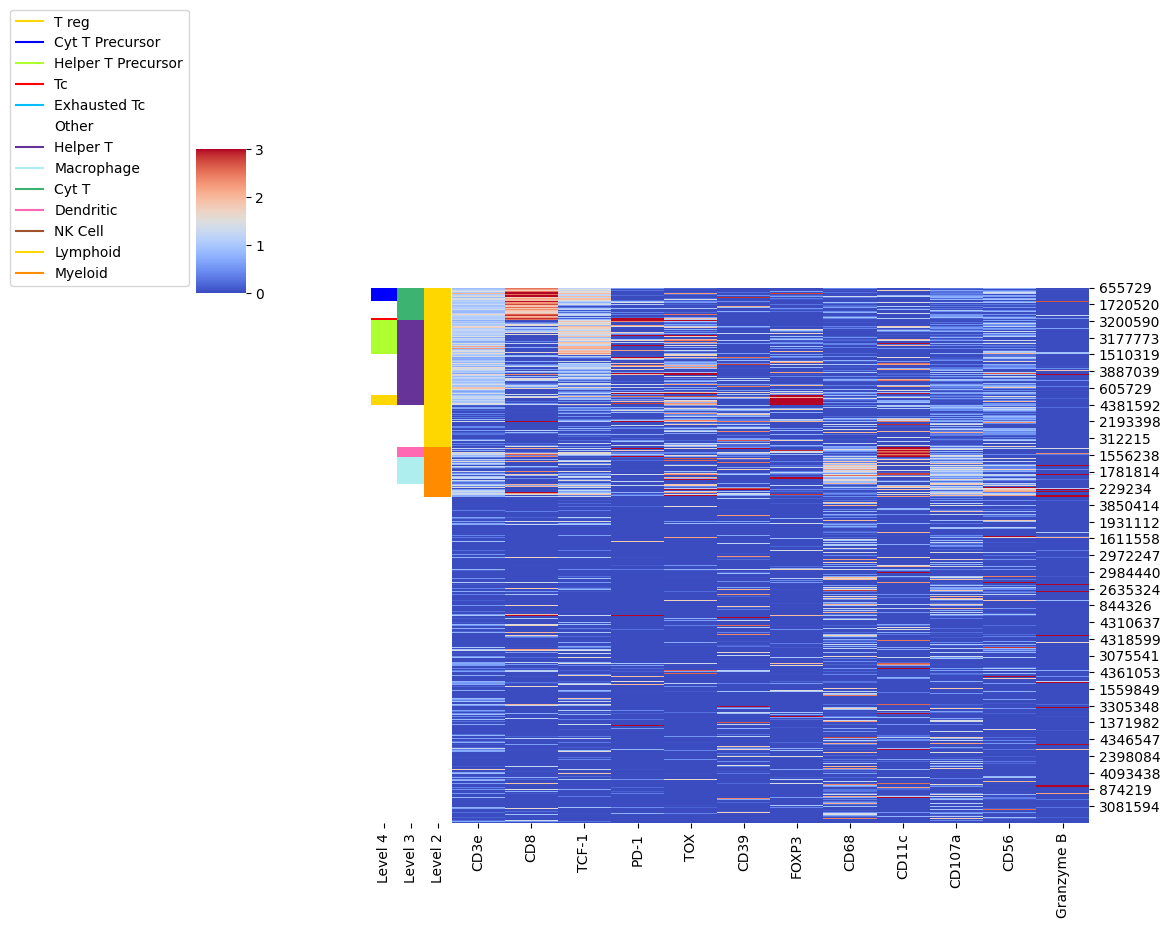

In [16]:
# plot
cm = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cm.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
colours = level4_colours | level3_colours | level2_colours
for label in colours:
    plt.plot([], [], color=colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

### Figure 2 plots

log2 fold change in proportions of each phenotype from pre to post DLN

In [22]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'UMAP1',
       'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint'],
      dtype='object')

In [25]:
phen_prop = df.groupby(['Parent', 'Timepoint', 'Phenotype']).size().unstack(fill_value=0)
prop_df = phen_prop.div(phen_prop.sum(axis=1), axis=0)
prop_df.head()

,Phenotype,Cyt T,Cyt T Precursor,Dendritic,Epithelial,Exhausted Tc,Helper T,Helper T Precursor,Immune,Lymphoid,Macrophage,Myeloid,NK Cell,Other,T reg,Tc
Parent,Timepoint,,,,,,,,,,,,,,,
Slide 10 C1,DLN post,0.014405,0.025525,0.006718,0.004389,0.000101,0.051680,0.079940,0.044333,0.136199,0.034352,0.009575,0.000189,0.560415,0.030773,0.001404
Slide 10 C1-1,DLN post,0.003491,0.001379,0.002849,0.000156,0.000000,0.013174,0.007924,0.061184,0.077791,0.031403,0.020155,0.000072,0.777117,0.002940,0.000365
Slide 10 D1,DLN post,0.009250,0.011774,0.008369,0.000473,0.000323,0.024703,0.035227,0.019963,0.052693,0.094965,0.002039,0.000192,0.720787,0.015896,0.003344
Slide 11 A1,DLN pre,0.044933,0.028037,0.063354,0.008735,0.000295,0.099941,0.069682,0.044689,0.079161,0.025849,0.029165,0.000093,0.476009,0.017712,0.012345
Slide 11 A1-1,DLN pre,0.037402,0.021429,0.012485,0.001781,0.000133,0.093590,0.044458,0.077981,0.072805,0.115879,0.026467,0.001487,0.468574,0.021559,0.003971


In [26]:
mean_prop = prop_df.groupby('Timepoint').mean()
mean_prop.head()

Phenotype,Cyt T,Cyt T Precursor,Dendritic,Epithelial,Exhausted Tc,Helper T,Helper T Precursor,Immune,Lymphoid,Macrophage,Myeloid,NK Cell,Other,T reg,Tc
Timepoint,,,,,,,,,,,,,,,
DLN post,0.022046,0.020825,0.009606,0.001279,0.000155,0.061117,0.054216,0.052775,0.083980,0.047533,0.017317,0.000240,0.609405,0.016667,0.002840
DLN pre,0.033449,0.024214,0.031359,0.002449,0.000441,0.071774,0.054253,0.054240,0.098208,0.064935,0.029158,0.000579,0.512049,0.017547,0.005346


In [27]:
log2_fold_change = np.log2(mean_prop.loc['DLN post'] / mean_prop.loc['DLN pre'])
log2_fold_change.head()

Phenotype
Cyt T             -0.601486
Cyt T Precursor   -0.217509
Dendritic         -1.706880
Epithelial        -0.937097
Exhausted Tc      -1.513846
dtype: float64

In [30]:
prop_df.head()

,Phenotype,Cyt T,Cyt T Precursor,Dendritic,Epithelial,Exhausted Tc,Helper T,Helper T Precursor,Immune,Lymphoid,Macrophage,Myeloid,NK Cell,Other,T reg,Tc
Parent,Timepoint,,,,,,,,,,,,,,,
Slide 10 C1,DLN post,0.014405,0.025525,0.006718,0.004389,0.000101,0.051680,0.079940,0.044333,0.136199,0.034352,0.009575,0.000189,0.560415,0.030773,0.001404
Slide 10 C1-1,DLN post,0.003491,0.001379,0.002849,0.000156,0.000000,0.013174,0.007924,0.061184,0.077791,0.031403,0.020155,0.000072,0.777117,0.002940,0.000365
Slide 10 D1,DLN post,0.009250,0.011774,0.008369,0.000473,0.000323,0.024703,0.035227,0.019963,0.052693,0.094965,0.002039,0.000192,0.720787,0.015896,0.003344
Slide 11 A1,DLN pre,0.044933,0.028037,0.063354,0.008735,0.000295,0.099941,0.069682,0.044689,0.079161,0.025849,0.029165,0.000093,0.476009,0.017712,0.012345
Slide 11 A1-1,DLN pre,0.037402,0.021429,0.012485,0.001781,0.000133,0.093590,0.044458,0.077981,0.072805,0.115879,0.026467,0.001487,0.468574,0.021559,0.003971


In [32]:
prop_df.columns

Index(['Cyt T', 'Cyt T Precursor', 'Dendritic', 'Epithelial', 'Exhausted Tc',
       'Helper T', 'Helper T Precursor', 'Immune', 'Lymphoid', 'Macrophage',
       'Myeloid', 'NK Cell', 'Other', 'T reg', 'Tc'],
      dtype='object', name='Phenotype')

In [36]:
p_values = []
for phenotype in prop_df.columns:
    prop_t1 = prop_df.xs('DLN pre', level='Timepoint')[phenotype]
    prop_t2 =  prop_df.xs('DLN post', level='Timepoint')[phenotype]

    # run independent t-test
    _, p_value = ttest_rel(prop_t1, prop_t2) 
    print(p_value)
    p_values.append(p_value)

0.518439986867017
0.6853088505982522
0.05537659030448391
0.1519017685846556
0.023162678638348297
0.7271175985970683
0.9986078010110704
0.9561167715815109
0.5714127925467117
0.5367142884020843
0.12919082934463913
0.2959939233244696
0.18198050237516178
0.9061633615894672
0.38589931783865294


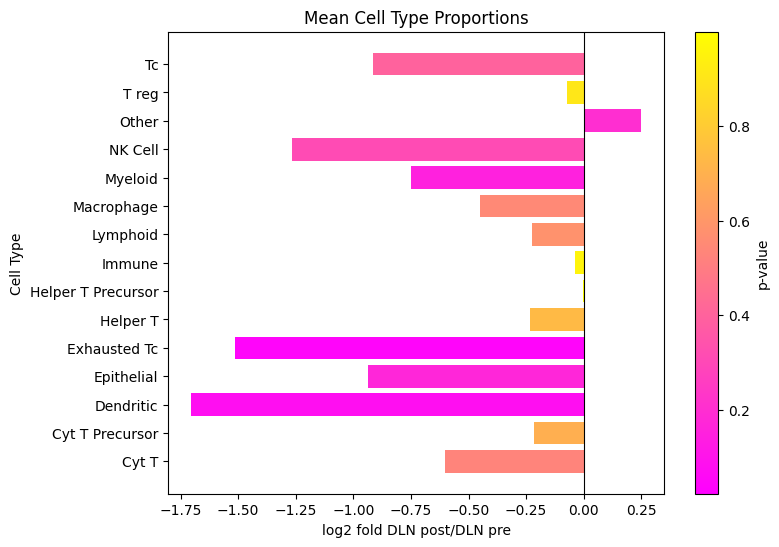

In [39]:
p_values = pd.Series(p_values, index=prop_df.columns)
cmap = mpl.cm.spring # colour map
colours = [cmap(p_val) for p_val in p_values]

# plot horizontal bar
fig, ax = plt.subplots(figsize=(8, 6))
phenotypes = log2_fold_change.index

bars = ax.barh(phenotypes, log2_fold_change, color=colours)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('log2 fold DLN post/DLN pre')
ax.set_ylabel('Cell Type')
ax.set_title('Mean Cell Type Proportions')

# p-value annotations
# for i, (log2_fc, p_val) in enumerate(zip(log2_fold_change, p_values)):
#     ax.text(log2_fc, i, f'p={p_val:.3e}', va='center', ha='right' if log2_fc < 0 else 'left')

# colour bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('p-value')

plt.show()

Plot change in ratio of phenotypes from pre to post DLN

In [ ]:
print(df['Phenotype'].unique())

In [ ]:
phen_ratios_toplot = [('Tc', 'Cyt T Precursor'), ('Helper T', 'Macrophage'), ('Cyt T Precursor', 'Helper T Precursor')]
for pair in phen_ratios_toplot:

    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):

            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # bar height = avg ratio for the timepoint
        bar_height = np.mean(sample_ratios) if sample_ratios else 0
        timepoint_dict[timepoint] = (bar_height, sample_ratios)

    # plot
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    
    bar_heights = [timepoint_dict.get(tp, (0, []))[0] for tp in timepoints]
    sample_ratios_list = [timepoint_dict.get(tp, ([], []))[1] for tp in timepoints]
    
    bars = ax.bar(timepoints, bar_heights, color='gainsboro', width=0.4)

    colors = {'DLN pre': 'red', 'DLN post': 'blue'}
    # add sample ratios as colored points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colors[timepoint], label=f'{timepoint} Sample Ratios', zorder=5)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Ratio')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()

In [ ]:
phen_ratios_toplot = [('Tc', 'Cyt T Precursor'), ('Helper T', 'Macrophage'), ('Cyt T Precursor', 'Helper T Precursor')]
for pair in phen_ratios_toplot:
    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):
            
            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
        
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # get avg ratio and stderr for the timepoint
        if sample_ratios:
            bar_height = np.mean(sample_ratios)
            std_error = np.std(sample_ratios, ddof=1) / np.sqrt(len(sample_ratios))
        else:
            bar_height = 0
            std_error = 0

        timepoint_dict[timepoint] = (bar_height, std_error, sample_ratios)

    # plot
    fig, ax = plt.subplots()

    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    bar_heights = [timepoint_dict[tp][0] for tp in timepoints]
    std_errors = [timepoint_dict[tp][1] for tp in timepoints]
    sample_ratios_list = [timepoint_dict[tp][2] for tp in timepoints]

    bars = ax.bar(timepoints, bar_heights, yerr=std_errors, color='gainsboro', width=0.4, capsize=5)
    colours = {'DLN pre': 'red', 'DLN post': 'blue'}  # updated colours dictionary

    # add sample ratios as coloured points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        if sample_ratios:  # unnecessary handling: check if there are ratios to plot
            ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colours[timepoint], label=f'{timepoint} Ratios', zorder=5)

    # determine whether not sig diff or sig, and display p-value if so
    for i in range(len(timepoints)):
        for j in range(i + 1, len(timepoints)):
            tp1 = timepoints[i]
            tp2 = timepoints[j]

            bar1, err1 = bar_heights[i], std_errors[i]
            bar2, err2 = bar_heights[j], std_errors[j]

            if (bar1 - err1 <= bar2 + err2) and (bar1 + err1 >= bar2 - err2):
                ax.text((i + j) / 2, max(bar_heights) + 0.1, 'n.s.', ha='center', va='bottom', fontsize=12)
            else:
                # two-tailed independent t-test
                _, p_value = ttest_ind(timepoint_dict[tp1][2], timepoint_dict[tp2][2], equal_var=False)
                if p_value < 0.1:
                    ax.text((i + j) / 2, max(bar_heights) + 0.1, f'p = {p_value:.2f}', ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel(f'# {pair[0]} Cells/# {pair[1]} Cells')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()


log2 fold change of biomarkers of interest from pre to post DLN in select phenotypes of interest

In [ ]:
print(df['Phenotype'].unique())

/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


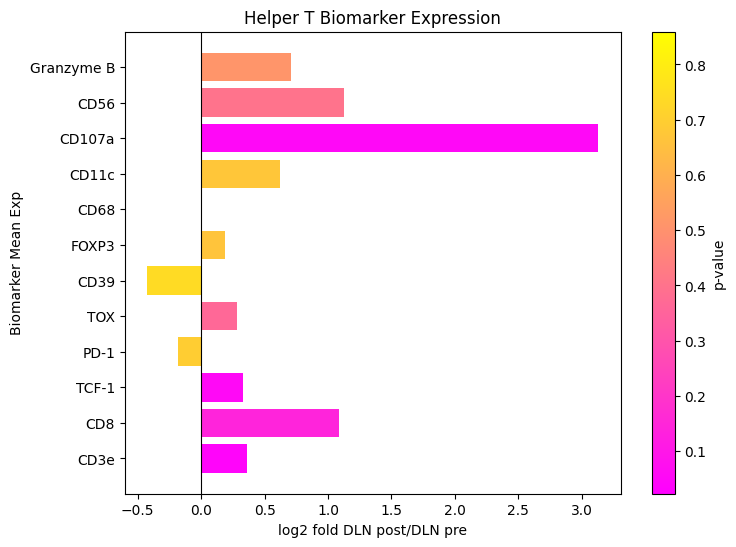

/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


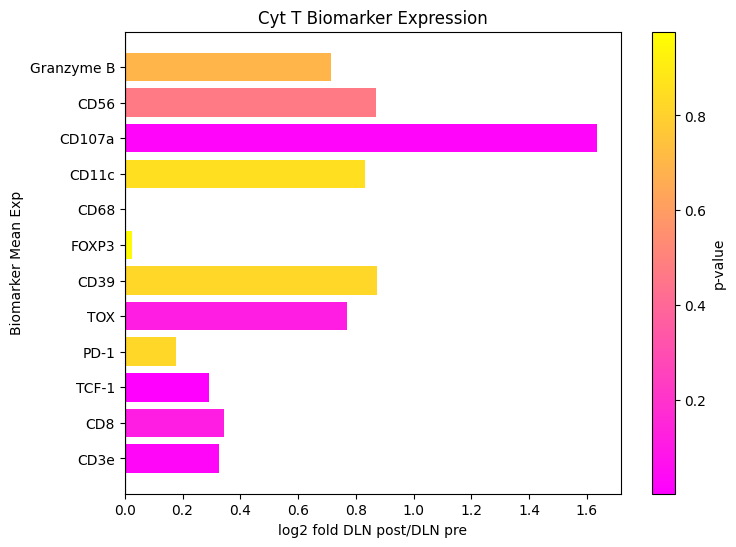

/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


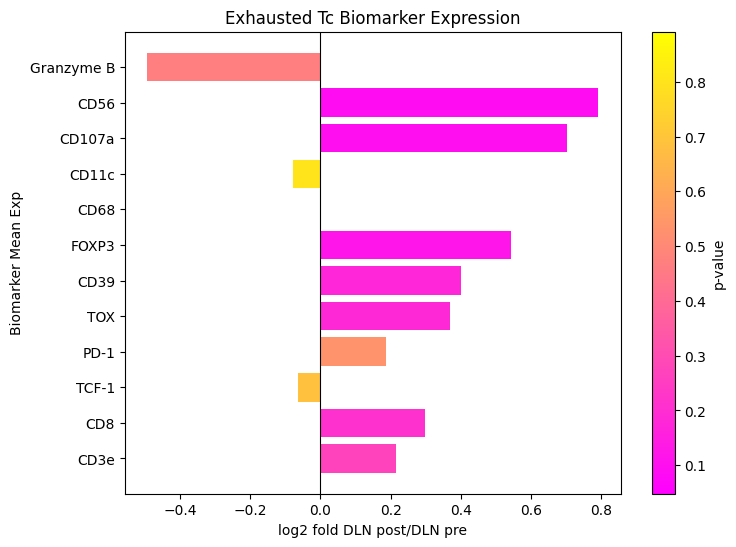

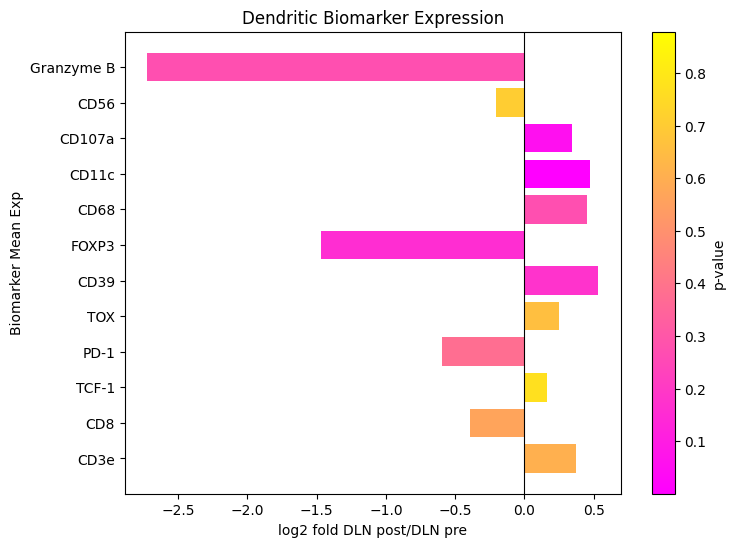

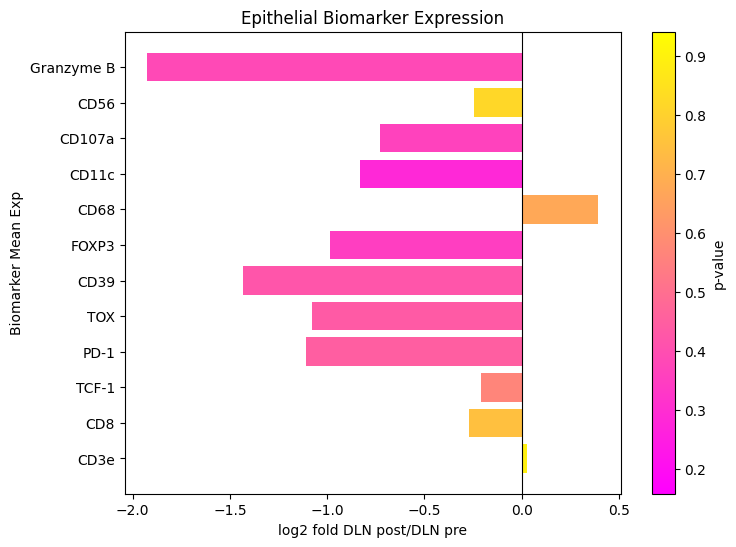

/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


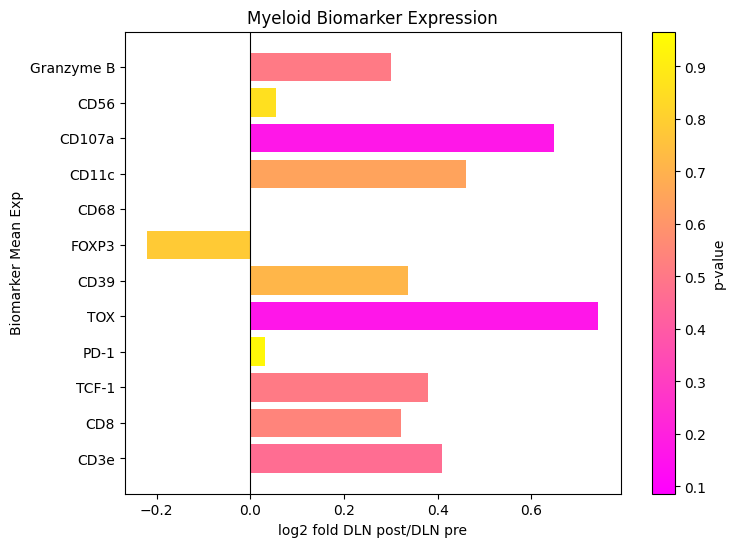

In [44]:
phenotypes_of_interest = ['Helper T', 'Cyt T', 'Exhausted Tc', 'Dendritic', 'Epithelial', 'Myeloid']
markers_oi = ['CD3e', 'CD8', 'TCF-1', 'PD-1', 'TOX', 'CD39', 'FOXP3', 'CD68', 'CD11c', 'CD107a', 'CD56', 'Granzyme B']

for phenotype in phenotypes_of_interest:
    # get phenotype of interest
    filtered_df = df[df['Phenotype'] == phenotype]

    mean_prop = filtered_df.groupby(['Parent', 'Timepoint', 'Phenotype'])[markers_oi].mean()
    mean_intensities = mean_prop.groupby('Timepoint')[markers_oi].mean()
    log2_fold_change = np.log2(mean_intensities.loc['DLN post'] / mean_intensities.loc['DLN pre'])

    # independent t-test to get p-values
    p_values = []
    for marker in markers_oi:
        values_t1 = mean_prop.xs('DLN pre', level='Timepoint')[marker] 
        values_t2 = mean_prop.xs('DLN post', level='Timepoint')[marker] 
        
        if len(values_t1) == len(values_t2):
            _, p_value = ttest_rel(values_t1, values_t2)
        else:
            _, p_value = ttest_ind(values_t1, values_t2, equal_var=False)
        p_values.append(p_value)

    p_values = pd.Series(p_values, index=markers_oi)
    cmap = mpl.cm.spring # colour map
    colours = [cmap(p_val) for p_val in p_values]

    # horizontal bar plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.barh(log2_fold_change.index, log2_fold_change, color=colours)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('log2 fold DLN post/DLN pre')
    ax.set_ylabel('Biomarker Mean Exp')
    ax.set_title(f'{phenotype} Biomarker Expression')

    # colour bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('p-value')

    plt.show()


In [ ]:
preparents = ['Slide 11 B1', 'Slide 11 A1', 'Slide 11 A1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1']
pre = df_ss[df_ss['Parent'].isin(preparents)]
post = df_ss[~df_ss['Parent'].isin(preparents)]

for tp in [('DLN Pre', pre), ('DLN Post', post)]:
    title, frame = tp
    corr = frame[markers_oi].corr()  # compute correlation matrix

    # mask for the upper triangle
    # mask = np.triu(np.ones_like(corr, dtype=bool))

    # plot 
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                # mask=mask, 
                cmap=mpl.cm.spring, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title(f'{title} correlation matrix of subset')


Heatmap of cell types and pre and post DLN

In [13]:
phenotype_counts = df.groupby(['Parent', 'Timepoint', 'Phenotype']).size().unstack(fill_value=0)
phenotype_counts.head()

,Phenotype,Cyt T,Cyt T Precursor,Dendritic,Epithelial,Exhausted Tc,Helper T,Helper T Precursor,Immune,Lymphoid,Macrophage,Myeloid,NK Cell,Other,T reg,Tc
Parent,Timepoint,,,,,,,,,,,,,,,
Slide 10 C1,DLN post,3272,5798,1526,997,23,11739,18158,10070,30937,7803,2175,43,127296,6990,319
Slide 10 C1-1,DLN post,919,363,750,41,0,3468,2086,16107,20479,8267,5306,19,204580,774,96
Slide 10 D1,DLN post,2404,3060,2175,123,84,6420,9155,5188,13694,24680,530,50,187321,4131,869
Slide 11 A1,DLN pre,16018,9995,22585,3114,105,35628,24841,15931,28220,9215,10397,33,169692,6314,4401
Slide 11 A1-1,DLN pre,23020,13189,7684,1096,82,57603,27363,47996,44810,71321,16290,915,288398,13269,2444


In [14]:
mean_counts = phenotype_counts.groupby('Timepoint').mean()
mean_counts.head()

Phenotype,Cyt T,Cyt T Precursor,Dendritic,Epithelial,Exhausted Tc,Helper T,Helper T Precursor,Immune,Lymphoid,Macrophage,Myeloid,NK Cell,Other,T reg,Tc
Timepoint,,,,,,,,,,,,,,,
DLN post,11451.166667,11183.666667,5881.833333,474.166667,61.166667,31727.500000,29512.000000,20449.166667,31175.500000,18178.833333,8698.000000,107.5,268452.666667,8284.333333,2030.000000
DLN pre,13366.166667,8766.333333,9193.833333,899.500000,149.500000,28448.166667,19929.666667,21221.833333,31230.666667,21474.666667,10846.166667,249.5,169089.666667,6920.500000,1982.833333


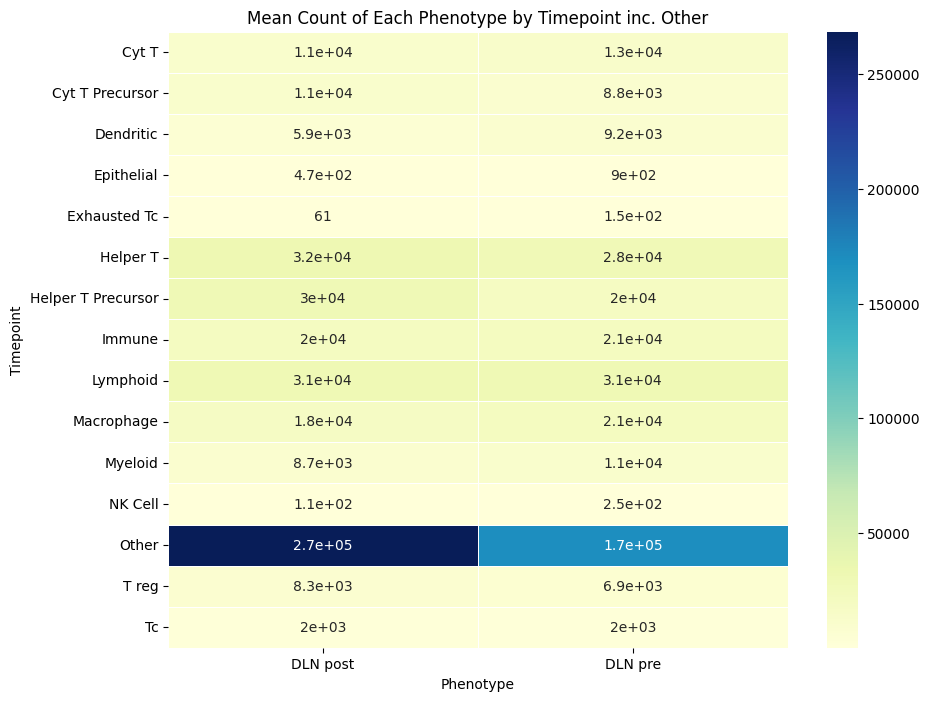

In [17]:
# plot
plt.figure(figsize=(10, 8))
sns.heatmap(mean_counts.T, annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Mean Count of Each Phenotype by Timepoint inc. Other')
plt.xlabel('Phenotype')
plt.ylabel('Timepoint')
plt.show()

In [20]:
wo_other = mean_counts.drop(columns=['Other'])
print(wo_other.columns)
wo_other = wo_other.T

Index(['Cyt T', 'Cyt T Precursor', 'Dendritic', 'Epithelial', 'Exhausted Tc',
       'Helper T', 'Helper T Precursor', 'Immune', 'Lymphoid', 'Macrophage',
       'Myeloid', 'NK Cell', 'T reg', 'Tc'],
      dtype='object', name='Phenotype')


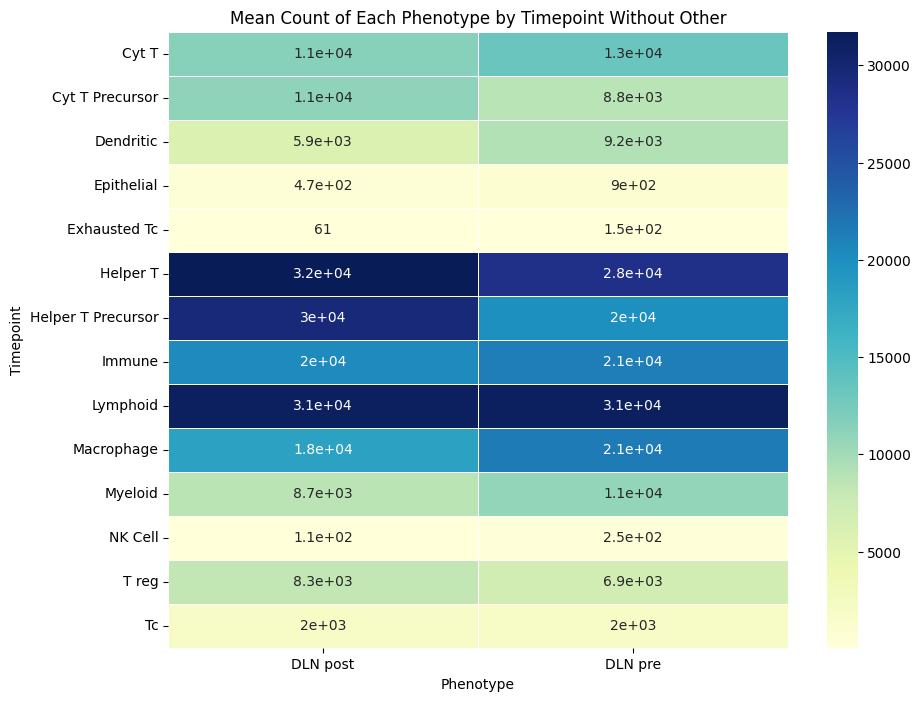

In [21]:
# plot
plt.figure(figsize=(10, 8))
sns.heatmap(wo_other, annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Mean Count of Each Phenotype by Timepoint Without Other')
plt.xlabel('Phenotype')
plt.ylabel('Timepoint')
plt.show()